# prediction electrical activity of the brain between the people drink alcohol and have a depression 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import threading
import warnings
warnings.filterwarnings('ignore', category=Warning)

In [3]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.19.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
[]


E0000 00:00:1747380383.761850   10372 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747380383.765814   10372 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
E0000 00:00:1747380383.927818   10372 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747380383.928535   10372 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed prop

In [4]:
data_list = []
for i in range(30):
    df = pd.read_csv(f'../../data/data_EEG/s{i:02d}.csv', header=None)
    data_list.append(df.transpose().to_numpy())

In [6]:
dataset_X = np.array(data_list)
dataset_X.shape

(30, 19, 31000)

In [7]:
dataset_X = dataset_X.reshape(30, 760, 775, 1).astype('float32')

# Leave-One-Out Cross-Validation (LOOCV) Explained

	Notice how rows 30-35 are excluded from the initial processing (like transpose and to_numpy) - these are reserved as the test set, not for validation!

	This method called Leave-One-Out Cross-Validation (LOOCV), is particularly valuable for EEG and other neuroimaging data because:

	Personalization Matters: Each participant has unique baseline brain activity, signal amplitudes, and response patterns

	Maximized Data Utility: With typical EEG studies having just 20-40 participants, LOOCV gives the most statistically reliable results

In [8]:
y = np.array([0,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1])
y = y.reshape(-1, 1)
y.shape

(30, 1)

In [9]:
import tensorflow as tf
print(tf.__version__)
a = tf.constant([1.0, 2.0])
b = tf.constant([3.0, 4.0])
c = a + b
print(c)

2.19.0
tf.Tensor([4. 6.], shape=(2,), dtype=float32)


In [10]:
seed = 42
tf.random.set_seed(seed)

# Model Building


# Early Stop:

	We introduced early stop here: early stop is a technique used to prevent overfitting. Patience=5 means with 5 consecutive 0 or negative improvement, we will stop trainning and return the best model.

# LSTM:

	The change I made is LSTM (Long-Short Term Memory), which is a special type of RNN that 'forgets' but not only 'remembers'. LSTM is useful for EEG data, since after one math task, the brain state data should approximated be set back to the baseline. This means forgetting is suitable for experiments with multiple discrete tasks.

# Convolutional Layers for Feature Extraction:

	I kept this part from the orgininal notebook. It uses Conv2D with 16 filters and strides of 2 to process the EEG's spatial dimensions, followed by max pooling and batch normalization to stabilize activations.

A 20% dropout layer helps prevent overfitting to electrode-specific noise. These layers extract localized spatial patterns from the raw input before reshaping for LSTM processing, preserving the critical spatial relationships between electrodes while reducing dimensionality.

The combination of strided convolutions and pooling ensures the network focuses on the most salient neural activity patterns. =) (why am I explaining this its father should have done the work!)

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model
model = tf.keras.models.Sequential([
    # Convolutional layers for feature extraction
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation='relu',
                           input_shape=(760, 775, 1), padding='same'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    # Reshape to fit LSTM input format
    tf.keras.layers.Reshape((190, -1)),  # Adjusted based on Conv2D+MaxPool2D output

    # LSTM for sequence modeling
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),

    # Fully connected output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 380, 388, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 190, 194, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 190, 194, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 190, 194, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 190, 3104)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 190, 64)        │       811,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,937 (3.14 MB)

 Trainable params: 823,905 (3.14 MB)

 Non-trainable params: 32 (128.00 B)

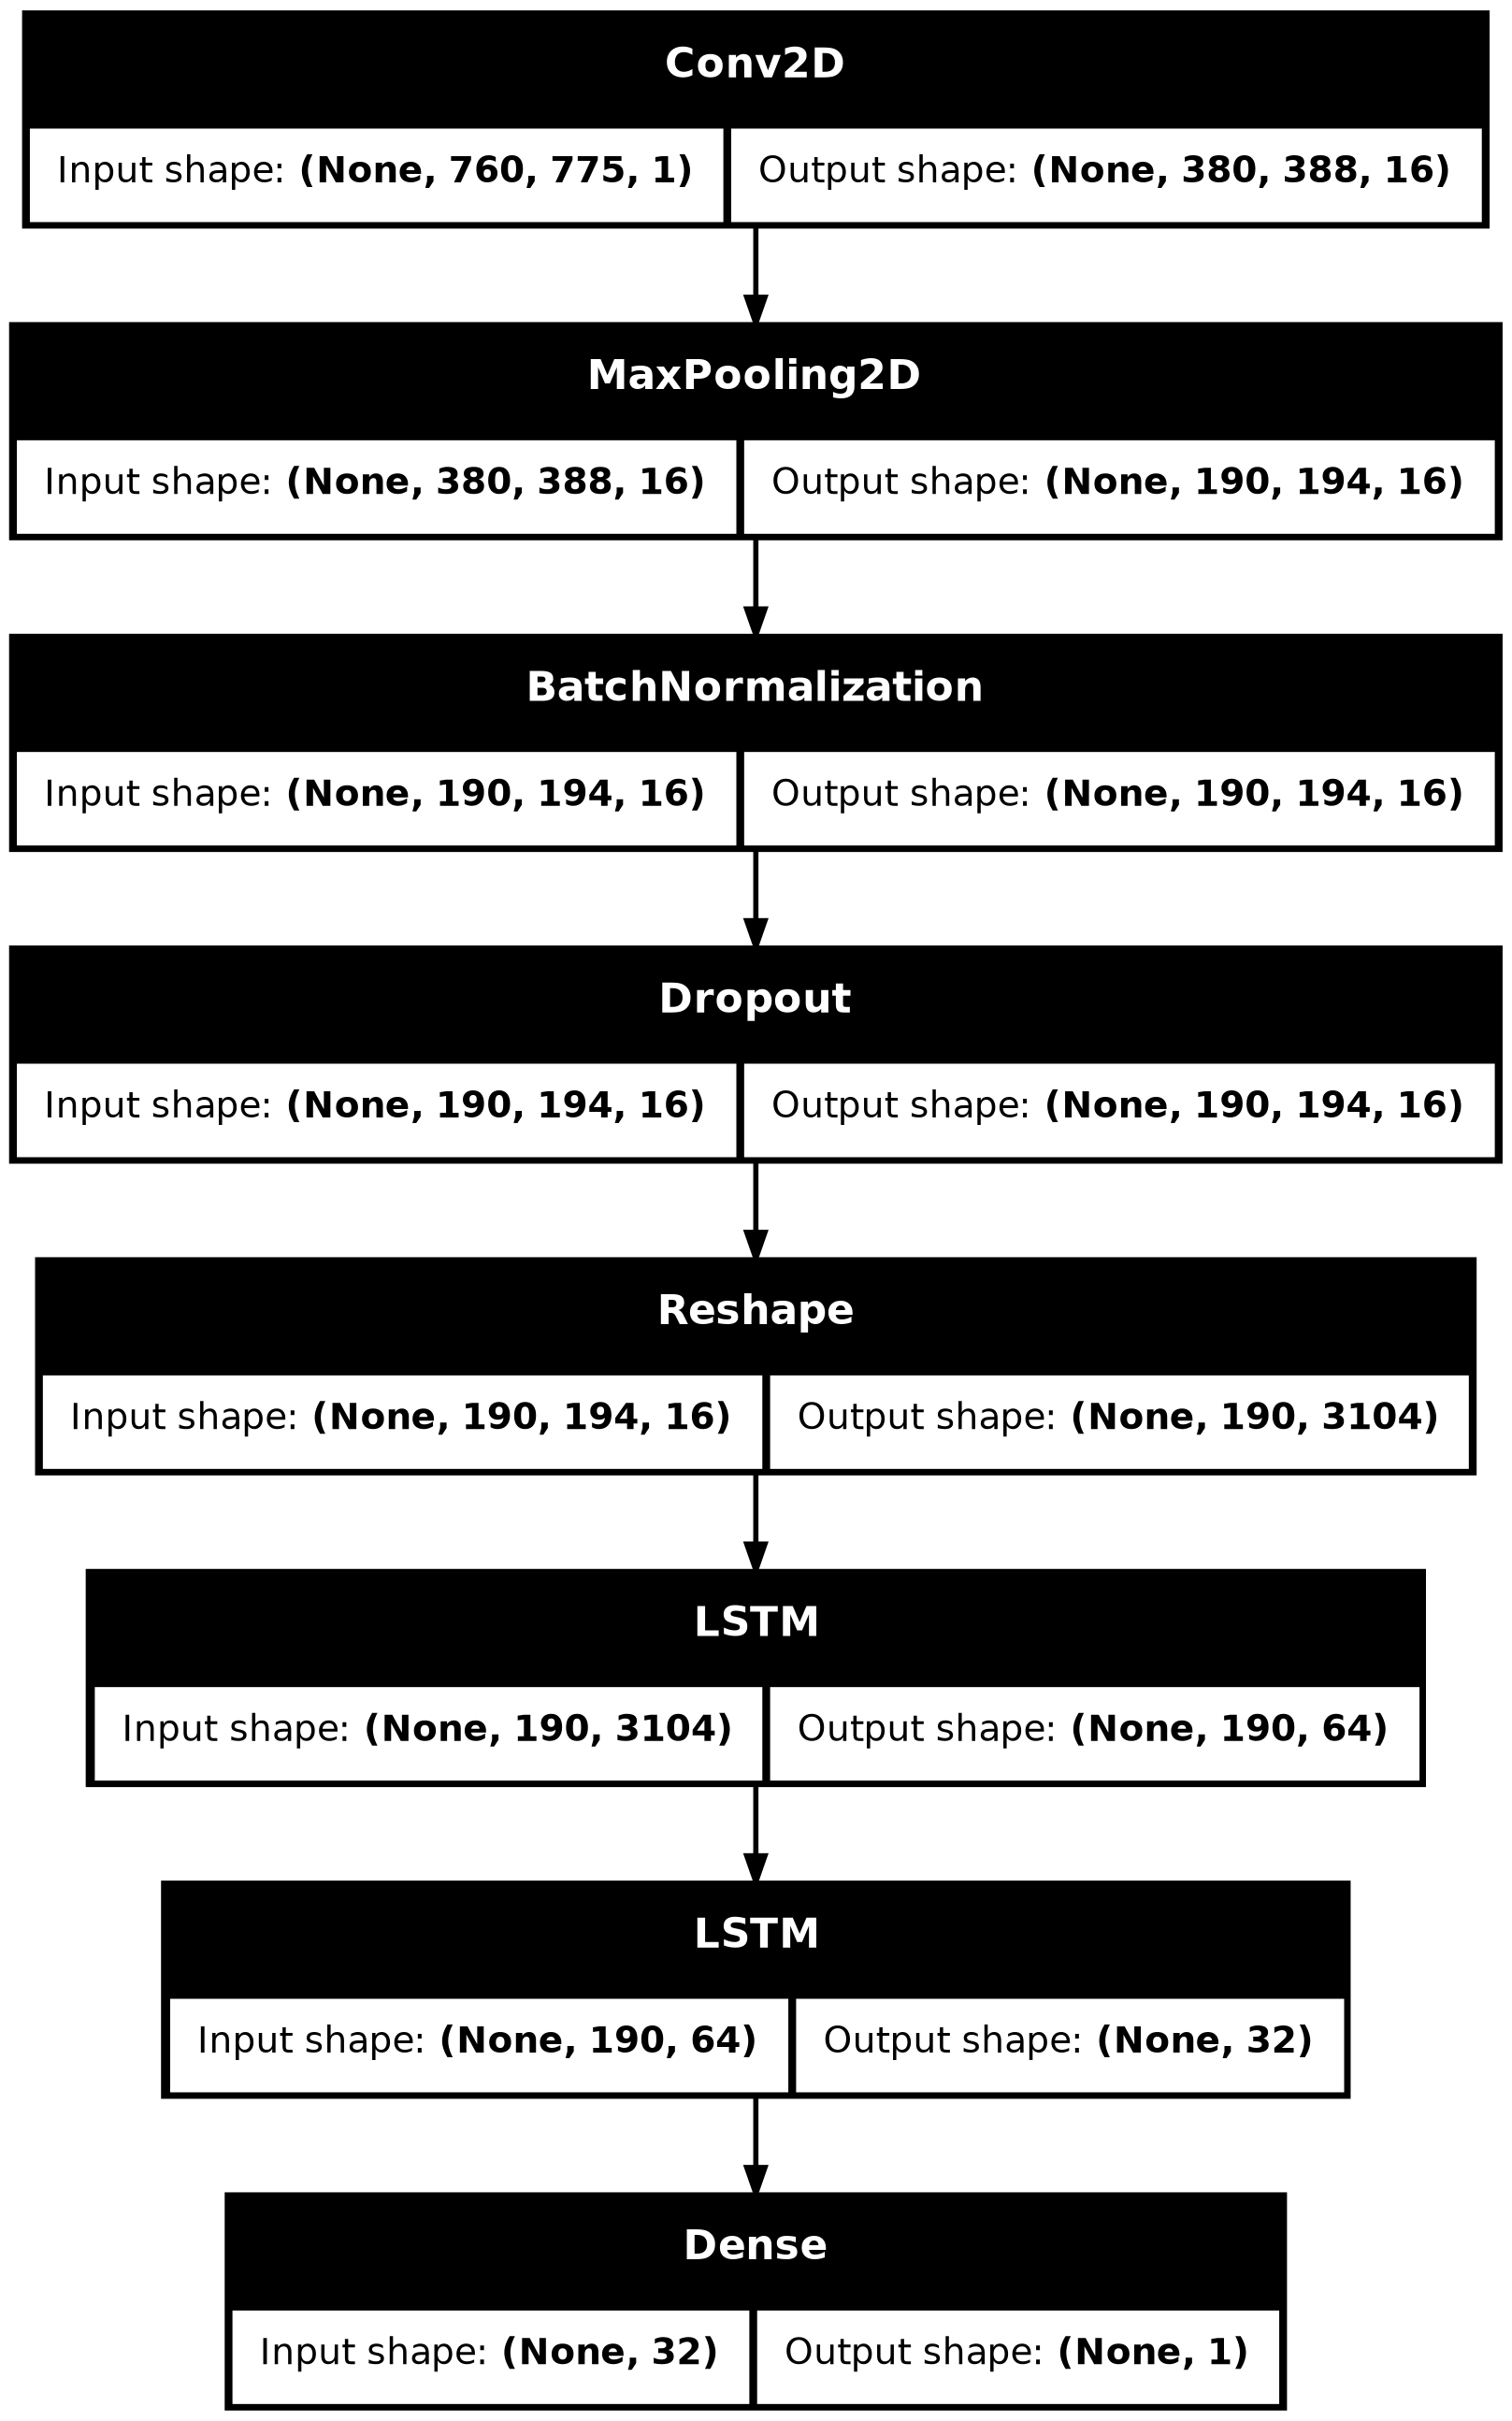

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')


In [13]:
model.fit(dataset_X, y, batch_size=1, epochs=25, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/25


2025-05-16 08:27:27.693545: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51832000 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3587 - auc: 0.4568 - loss: 0.6893 - precision: 0.4893 - recall: 0.4585 - val_accuracy: 0.1250 - val_auc: 0.5000 - val_loss: 1.0744 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 992ms/step - accuracy: 1.0000 - auc: 0.9130 - loss: 0.2536 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.2500 - val_auc: 0.7857 - val_loss: 0.9067 - val_precision: 1.0000 - val_recall: 0.1429
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 1.0000 - auc: 0.9130 - loss: 0.1057 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.2500 - val_auc: 0.7143 - val_loss: 0.9714 - val_precision: 1.0000 - val_recall: 0.1429
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 1.0000 - auc: 0.9130 - loss: 0.0500 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.2500 - val_auc: 0.5714 - val_loss: 1.0667 - val_precision: 1.0000 - val_recall: 0.1429
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 29

In [14]:
loss,acc,rec,auc,per=model.evaluate(dataset_X, y ,batch_size=1)

2025-05-16 08:31:09.799138: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 70680000 exceeds 10% of free system memory.


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9682 - auc: 0.9662 - loss: 0.3501 - precision: 0.9677 - recall: 0.9211


In [15]:
f1 = 2*(per*rec)/(per+rec)

In [16]:
print(f'This is a precision {per}')
print(f'This is a accuracy {acc}')
print(f'This is a recall {rec}')

print(f'This is a f1 score {f1}')

This is a precision 1.0
This is a accuracy 0.800000011920929
This is a recall 0.7142857313156128
This is a f1 score 0.8333333449231253


In [18]:
data_list_test = []
for i in range(30,36):
    df = pd.read_csv(f'../../data/data_EEG/s{i:02d}.csv', header=None)
    data_list_test.append(df.transpose().to_numpy())

In [19]:
dataset_y = np.array(data_list_test)

In [20]:
dataset_y.shape


(6, 19, 31000)

In [21]:
dataset_y = dataset_y.reshape(6, 760, 775, 1).astype('float32')

In [22]:
y_tets = np.array([0, 1, 1, 1, 0, 1])
y_tets = y_tets.reshape(-1, 1)
y_tets.shape

(6, 1)

In [23]:
model.fit(dataset_y, y_tets, batch_size=1, epochs=25, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/25


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8333 - auc: 0.6000 - loss: 0.3972 - precision: 0.8333 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5733 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - auc: 0.6000 - loss: 0.1258 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5000 - val_auc: 1.0000 - val_loss: 0.6303 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - auc: 0.6000 - loss: 0.0939 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5000 - val_auc: 1.0000 - val_loss: 0.7091 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - auc: 0.6000 - loss: 0.0684 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5000 - val_auc: 1.0000 - val_loss: 0.7533 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.00

In [24]:
loss_test,acc_test,rec_test,auc_test,per_test=model.evaluate(dataset_y, y_tets ,batch_size=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - accuracy: 1.0000 - auc: 0.8571 - loss: 0.3938 - precision: 0.8571 - recall: 0.8571       


In [25]:
f1_tets = 2*(per_test*rec_test)/(per_test+rec_test)

In [26]:
print(f'This is a precision {per_test}')
print(f'This is a accuracy {acc_test}')
print(f'This is a recall {rec_test}')

print(f'This is a f1 score {f1_tets}')

This is a precision 1.0
This is a accuracy 1.0
This is a recall 1.0
This is a f1 score 1.0


In [28]:
dataset_all_ = []
for i in range(1,36):
    df = pd.read_csv(f'../../data/data_EEG/s{i:02d}.csv', header=None)
    dataset_all_.append(df.transpose().to_numpy())

In [29]:
dataset_all = np.array(dataset_all_)


In [30]:
dummy = np.zeros((1, 19, 31000), dtype=dataset_all.dtype)
dataset_all = np.concatenate([dataset_all, dummy], axis=0)
dataset_all = dataset_all.reshape(36, 1, 19, 31000)


In [31]:
dataset_all.shape

(36, 1, 19, 31000)

In [32]:


# Function that seperates two gorups' EEG -- it's okay! 15+ participants each is not a small number
def plot_eeg_group_difference(X, y):
    # Separate EEG data into two groups based on math performance
    X_good = X[y == 1]  # Good math performers
    X_bad = X[y == 0]   # Bad math performers
    
    # Compute the average EEG signal over all channels and subjects for each group
    mean_good = np.mean(X_good, axis=(0, 2))  # Averaged over subjects & channels
    mean_bad = np.mean(X_bad, axis=(0, 2))
    
    # Time axis (assuming time_steps exist)
    time = np.arange(mean_good.shape[0])
    
    # Plot the EEG signal for both groups
    plt.figure(figsize=(10, 5))
    plt.plot(time, mean_good, label='Good Math Performers (y=1)', color='blue')
    plt.plot(time, mean_bad, label='Bad Math Performers (y=0)', color='red', linestyle='dashed')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Mean EEG Signal')
    plt.title('EEG Signal Differences: Good vs. Bad Math Performers')
    plt.legend()
    plt.grid(True)
    plt.show()



In [33]:
y_all=np.array([0,1,1,1,0,1,0,1,1,0,0 ,1 ,1 ,1 ,0 ,1 ,1 ,1 ,1 ,0 ,1 ,0 ,0 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,0 ,1 ,1 ,1 ,1 ,1 ])
y_all=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35])


In [53]:


factor = 20

# Downsample EEG: average every `factor` time steps
def downsample_eeg(data, factor=20):
    num_subjects, num_channels, num_electrodes, num_time_steps = data.shape

    new_time_steps = num_time_steps // factor
    data = data[:, :, :, :new_time_steps * factor]# Trim excess
    
    #Reshape and average
    data = data.reshape(num_subjects, num_channels, num_electrodes, new_time_steps, factor)
    data = np.mean(data, axis=-1)  #Take mean over last axis(time factor)

    return data



In [54]:
# Downsample EEG data (31000 → 1550)
dataset_all_downsampled = downsample_eeg(dataset_all, factor)

# Sampling rate of EEG data
sampling_rate = 500  # Hz
time_per_sample = factor / sampling_rate  # Time duration per downsampled point

# Separate the dataset into two groups based on `y` values (labels)
X_good = dataset_all_downsampled[y_all == 1]  # Good @ math
X_bad = dataset_all_downsampled[y_all == 0]   # Bad @ math

# Split dataset into 10 equal sections
num_splits = 10
split_size = dataset_all_downsampled.shape[-1] // num_splits  # 155 time steps per split


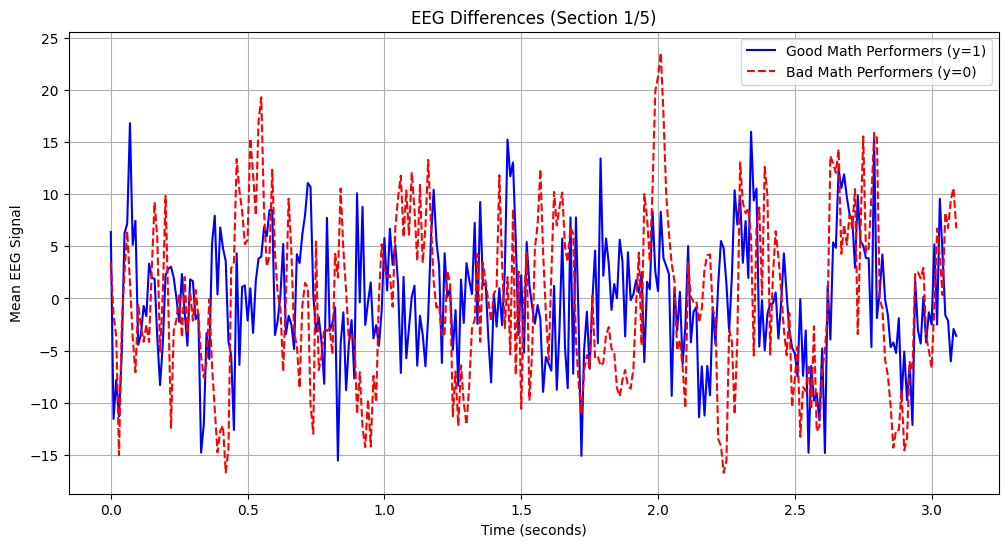

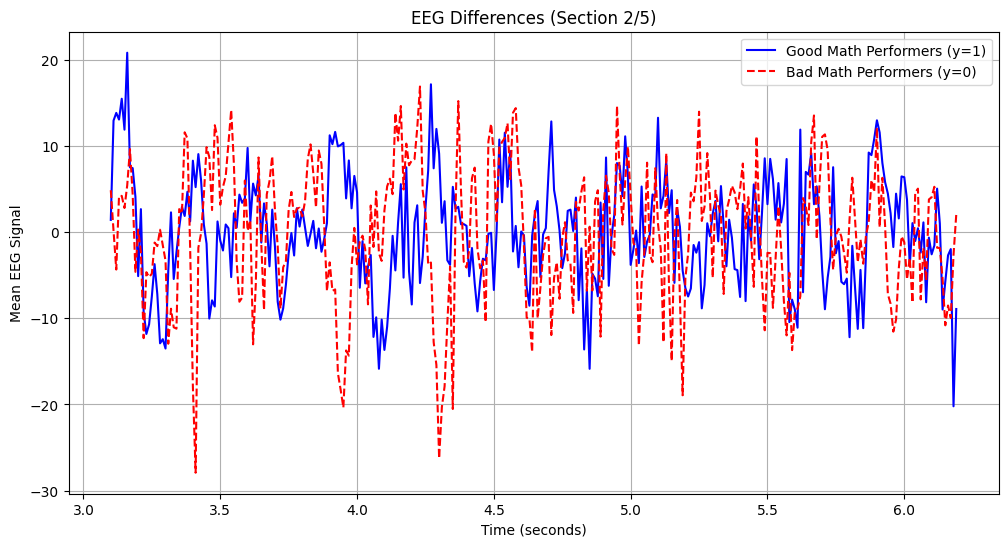

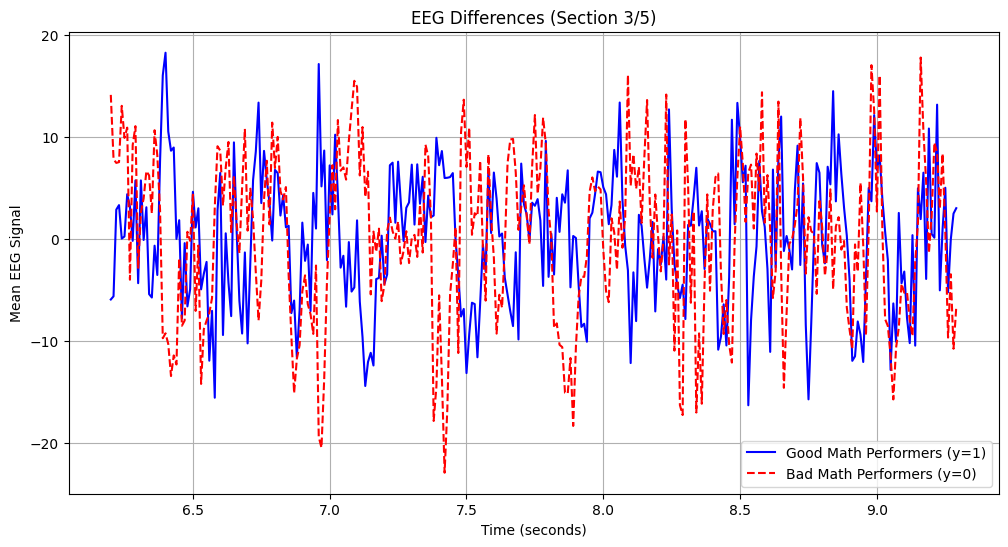

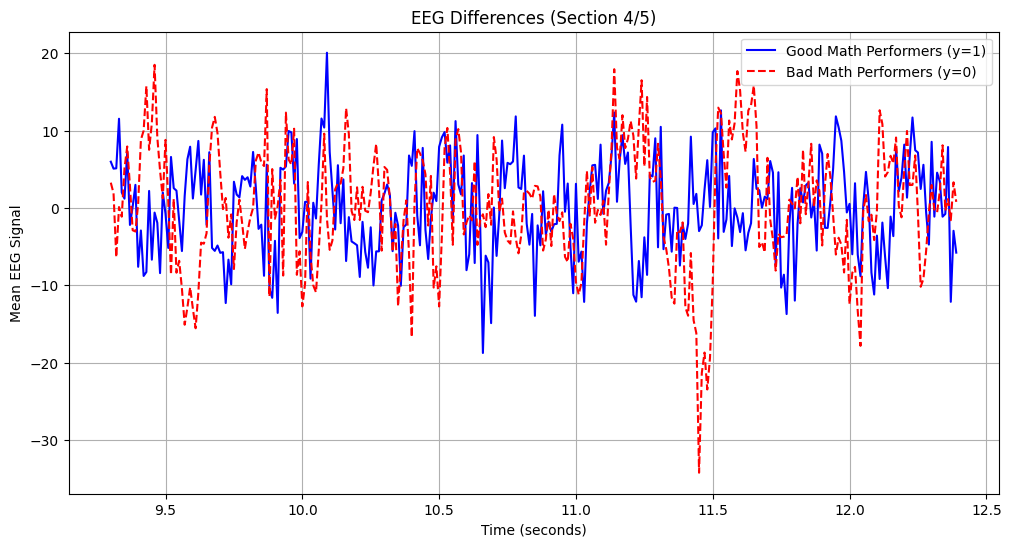

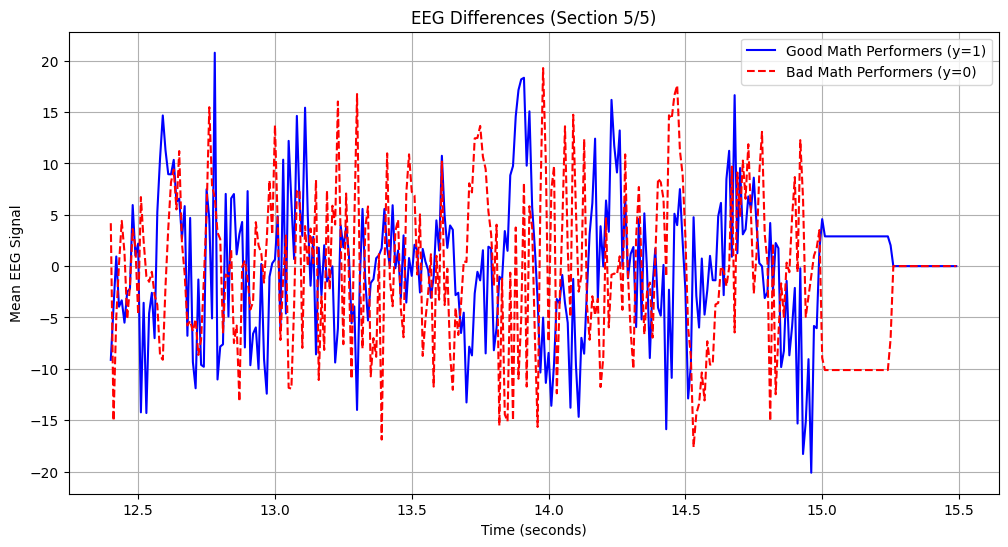

In [58]:
# Loop through and plot separately
for i in range(num_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size

    # Get the current section of EEG data for both groups
    section_good = X_good[:, :, :, start_idx:end_idx]
    section_bad = X_bad[:, :, :, start_idx:end_idx]

    # Compute the mean EEG signal for each group (average over subjects and electrodes)
    mean_good = np.mean(section_good, axis=(0, 2))  # Averaging over subjects & electrodes
    mean_bad = np.mean(section_bad, axis=(0, 2))

    # Compute actual time points
    time_axis = np.arange(start_idx, end_idx) * time_per_sample  # Convert indices to actual time

    # Plot the results
    plt.figure(figsize=(12, 6))  # Increase figure size
    plt.plot(time_axis, mean_good[0], label="Good Math Performers (y=1)", color='blue')
    plt.plot(time_axis, mean_bad[0], label="Bad Math Performers (y=0)", color='red', linestyle='dashed')

    plt.xlabel("Time (seconds)")
    plt.ylabel("Mean EEG Signal")
    plt.title(f"EEG Differences (Section {i+1}/{num_splits})")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.pause(2)  # Pause before showing the next plot